# Natural Language Processing Lab

In this lab we will further explore Scikit's and NLTK's capabilities to process text. We will use the 20 Newsgroup dataset, which is provided by Scikit-Learn.

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
from sklearn.datasets import fetch_20newsgroups

In [10]:
import logging
logging.basicConfig()

In [11]:
categories = [
    'alt.atheism',
    'talk.religion.misc',
    'comp.graphics',
    'sci.space',
]

data_train = fetch_20newsgroups(subset='train', categories=categories,
                                shuffle=True, random_state=42,
                                remove=('headers', 'footers', 'quotes'))

data_test = fetch_20newsgroups(subset='test', categories=categories,
                               shuffle=True, random_state=42,
                               remove=('headers', 'footers', 'quotes'))

## 1. Data inspection

We have downloaded a few newsgroup categories and removed headers, footers and quotes.

Let's inspect them.

1. What data taype is `data_train`
> sklearn.datasets.base.Bunch
- Is it like a list? Or like a Dictionary? or what?
> Dict
- How many data points does it contain?
- Inspect the first data point, what does it look like?
> A blurb of text

In [19]:
type(data_train)

sklearn.datasets.base.Bunch

In [21]:
data_train.description

'the 20 newsgroups by date dataset'

In [24]:
len(data_train.data)

2034

In [26]:
data_train.data[0]

u"Hi,\n\nI've noticed that if you only save a model (with all your mapping planes\npositioned carefully) to a .3DS file that when you reload it after restarting\n3DS, they are given a default position and orientation.  But if you save\nto a .PRJ file their positions/orientation are preserved.  Does anyone\nknow why this information is not stored in the .3DS file?  Nothing is\nexplicitly said in the manual about saving texture rules in the .PRJ file. \nI'd like to be able to read the texture rule information, does anyone have \nthe format for the .PRJ file?\n\nIs the .CEL file format available from somewhere?\n\nRych"

## 2. Bag of Words model

Let's train a model using a simple count vectorizer

1. Initialize a standard CountVectorizer and fit the training data
- how big is the feature dictionary
- repeat eliminating english stop words
- is the dictionary smaller?
- transform the training data using the trained vectorizer
- what are the 20 words that are most common in the whole corpus?
- what are the 20 most common words in each of the 4 classes?
- evaluate the performance of a Lotistic Regression on the features extracted by the CountVectorizer
    - you will have to transform the test_set too. Be carefule to use the trained vectorizer, without re-fitting it
- try the following 3 modification:
    - restrict the max_features
    - change max_df and min_df
    - use a fixed vocabulary of size 80 combining the 20 most common words per group found earlier
- for each of the above print a confusion matrix and investigate what gets mixed
> Anwer: not surprisingly if we reduce the feature space we lose accuracy
- print out the number of features for each model

In [100]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [28]:
cv = CountVectorizer(stop_words="english")

In [34]:
words = cv.fit_transform(data_train.data).todense()

In [35]:
words.shape

(2034, 26576)

In [36]:
len(cv.get_feature_names())

26576

In [37]:
df = pd.DataFrame(words, columns=cv.get_feature_names())

In [43]:
df.sum().sort_values(ascending=False).head(20)

space       1061
people       793
god          745
don          730
like         682
just         675
does         600
know         592
think        584
time         546
image        534
edu          501
use          468
good         449
data         444
nasa         419
graphics     414
jesus        411
say          409
way          387
dtype: int64

In [52]:
data_train.target_names

['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']

In [81]:
y = pd.DataFrame(data_train.target, columns =["y"])
y_train = y["y"]

In [67]:
df2 = pd.concat([df, y], axis=1)

In [90]:
vocabulary = []
for i in df2["y"].unique():
    top_20 = df2.iloc[:,:-1][df2["y"] == i].sum().sort_values(ascending=False).head(20)
    print top_20.index
    vocabulary.extend(top_20.index.tolist())

Index([u'image', u'graphics', u'edu', u'jpeg', u'file', u'use', u'data',
       u'files', u'images', u'software', u'program', u'ftp', u'available',
       u'format', u'color', u'like', u'know', u'pub', u'gif', u'does'],
      dtype='object')
Index([u'god', u'people', u'jesus', u'don', u'bible', u'just', u'think',
       u'christian', u'say', u'know', u'does', u'did', u'like', u'good',
       u'life', u'way', u'believe', u'said', u'point', u'time'],
      dtype='object')
Index([u'space', u'nasa', u'launch', u'earth', u'like', u'data', u'orbit',
       u'time', u'shuttle', u'just', u'satellite', u'lunar', u'moon', u'new',
       u'program', u'don', u'year', u'people', u'mission', u'use'],
      dtype='object')
Index([u'god', u'people', u'don', u'think', u'just', u'does', u'atheism',
       u'say', u'believe', u'like', u'atheists', u'religion', u'jesus',
       u'know', u'argument', u'time', u'said', u'true', u'bible', u'way'],
      dtype='object')


In [78]:
test_words = cv.transform(data_test.data).todense()
X_test = pd.DataFrame(test_words, columns = cv.get_feature_names())

In [82]:
y_test = data_test.target

In [84]:
logreg = LogisticRegression()
logreg.fit(df, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [85]:
y_pred = logreg.predict(X_test)

In [86]:
logreg.score(X_test, y_test)

0.74501108647450109

In [135]:
def check_cv(cv_model, class_model):
    cv_model.fit(data_train.data)

    X_train = pd.DataFrame(cv_model.transform(data_train.data).todense())
    X_test = pd.DataFrame(cv_model.transform(data_test.data).todense())
    class_model.fit(X_train, y_train)
    print "Model Score: {}".format(class_model.score(X_test, y_test))
    print "Features: {}".format(X_train.shape[1])

    conmat = pd.DataFrame(metrics.confusion_matrix(y_test, class_model.predict(X_test)), index=data_train.target_names,
                          columns=data_train.target_names)
    return conmat

In [136]:
check_cv(CountVectorizer(stop_words="english", max_features=400), LogisticRegression())

Model Score: 0.659275683666
Features: 400


,alt.atheism,comp.graphics,sci.space,talk.religion.misc
alt.atheism,184,17,45,73
comp.graphics,19,323,41,6
sci.space,57,31,280,26
talk.religion.misc,105,20,21,105


In [137]:
check_cv(CountVectorizer(stop_words="english", max_df=0.5, min_df=0.1), LogisticRegression())

Model Score: 0.441241685144
Features: 18


,alt.atheism,comp.graphics,sci.space,talk.religion.misc
alt.atheism,116,125,41,37
comp.graphics,30,287,67,5
sci.space,39,181,170,4
talk.religion.misc,88,112,27,24


In [138]:
check_cv(CountVectorizer(stop_words="english", vocabulary=set(vocabulary)), LogisticRegression())

Model Score: 0.589061345159
Features: 54


,alt.atheism,comp.graphics,sci.space,talk.religion.misc
alt.atheism,160,67,33,59
comp.graphics,25,314,44,6
sci.space,37,88,247,22
talk.religion.misc,90,70,15,76


## 3. Hashing and TF-IDF

Let's see if Hashing or TF-IDF improves the accuracy.

1. Initialize a HashingVectorizer and repeat the test with no restriction on the number of features
- does the score improve with respect to the count vectorizer?
    - can you change any of the default parameters to improve it?
- print out the number of features for this model
- Initialize a TF-IDF Vectorizer and repeat the analysis above
- can you improve on your best score above?
    - can you change any of the default parameters to improve it?
- print out the number of features for this model

In [121]:
from sklearn.feature_extraction.text import HashingVectorizer, TfidfVectorizer

In [141]:
check_cv(TfidfVectorizer(stop_words="english", max_features=1000), LogisticRegression())

Model Score: 0.726533628973
Features: 1000


,alt.atheism,comp.graphics,sci.space,talk.religion.misc
alt.atheism,185,16,63,55
comp.graphics,7,343,37,2
sci.space,23,26,337,8
talk.religion.misc,79,15,39,118


In [140]:
check_cv(HashingVectorizer(), LogisticRegression())

Model Score: 0.674057649667
Features: 1048576


,alt.atheism,comp.graphics,sci.space,talk.religion.misc
alt.atheism,180,41,54,44
comp.graphics,15,337,34,3
sci.space,29,47,315,3
talk.religion.misc,100,29,42,80


## 4. Classifier comparison

Of all the vectorizers tested above, choose one that has a reasonable performance with a manageable number of features and compare the performance of these models:

- KNN
- Logistic Regression
- Decision Trees
- Support Vector Machine
- Random Forest
- Extra Trees

In order to speed up the calculation it's better to vectorize the data only once and then compare the models.

In [152]:
from sklearn import neighbors, tree, ensemble, linear_model, svm

In [147]:
tfidf = TfidfVectorizer(stop_words="english", max_features=1000)
tfidf.fit(data_train.data)

X_train = pd.DataFrame(tfidf.transform(data_train.data).todense())
X_test = pd.DataFrame(tfidf.transform(data_test.data).todense())

In [148]:
def eval_model(class_model):
    class_model.fit(X_train, y_train)
    print "Model Score: {}".format(class_model.score(X_test, y_test))
    print "Features: {}".format(X_train.shape[1])
    conmat = pd.DataFrame(metrics.confusion_matrix(y_test, class_model.predict(X_test)), index=data_train.target_names,
                          columns=data_train.target_names)
    return conmat

In [149]:
eval_model(LogisticRegression())

Model Score: 0.726533628973
Features: 1000


,alt.atheism,comp.graphics,sci.space,talk.religion.misc
alt.atheism,185,16,63,55
comp.graphics,7,343,37,2
sci.space,23,26,337,8
talk.religion.misc,79,15,39,118


In [150]:
eval_model(neighbors.KNeighborsClassifier())

Model Score: 0.30081300813
Features: 1000


,alt.atheism,comp.graphics,sci.space,talk.religion.misc
alt.atheism,139,74,72,34
comp.graphics,148,134,69,38
sci.space,158,99,101,36
talk.religion.misc,104,58,56,33


In [151]:
eval_model(tree.DecisionTreeClassifier())

Model Score: 0.579453067258
Features: 1000


,alt.atheism,comp.graphics,sci.space,talk.religion.misc
alt.atheism,140,28,49,102
comp.graphics,25,275,58,31
sci.space,43,38,251,62
talk.religion.misc,93,23,17,118


In [153]:
eval_model(svm.SVC())

Model Score: 0.291204730229
Features: 1000


,alt.atheism,comp.graphics,sci.space,talk.religion.misc
alt.atheism,0,0,319,0
comp.graphics,0,0,389,0
sci.space,0,0,394,0
talk.religion.misc,0,0,251,0


In [154]:
eval_model(ensemble.RandomForestClassifier())

Model Score: 0.643015521064
Features: 1000


,alt.atheism,comp.graphics,sci.space,talk.religion.misc
alt.atheism,177,19,38,85
comp.graphics,18,325,31,15
sci.space,46,37,278,33
talk.religion.misc,115,19,27,90


In [155]:
eval_model(ensemble.ExtraTreesClassifier())

Model Score: 0.674057649667
Features: 1000


,alt.atheism,comp.graphics,sci.space,talk.religion.misc
alt.atheism,190,27,32,70
comp.graphics,18,336,25,10
sci.space,41,42,276,35
talk.religion.misc,107,23,11,110


## Bonus: Other classifiers

Adapt the code from [this example](http://scikit-learn.org/stable/auto_examples/text/document_classification_20newsgroups.html#example-text-document-classification-20newsgroups-py) to compare across all the classifiers suggested and to display the final plot

Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver='lsqr',
        tol=0.01)
train time: 1.682s
test time:  0.019s
accuracy:   0.712
dimensionality: 1000
density: 1.000000
top 10 keywords per class:
alt.atheism: stay tells satan religion atheist punishment islamic atheists at...
comp.graphics: image using card looking points file hi 3d computer graphics
sci.space: allen 23 flight engineering star spacecraft nasa sci orbit space
talk.religion.misc: shall sin christ context creation children christian orde...

classification report:
                    precision    recall  f1-score   support

       alt.atheism       0.62      0.55      0.58       319
     comp.graphics       0.84      0.85      0.84       389
         sci.space       0.72      0.84      0.77       394
talk.religion.misc 

/Users/joce/anaconda2/lib/python2.7/site-packages/sklearn/svm/classes.py:199: DeprecationWarning: loss='l2' has been deprecated in favor of loss='squared_hinge' as of 0.16. Backward compatibility for the loss='l2' will be removed in 1.0
  DeprecationWarning)


train time: 0.780s
test time:  0.003s
accuracy:   0.680
dimensionality: 1000
density: 0.997500
top 10 keywords per class:
alt.atheism: social stay natural valid eternal tells islamic atheists bobby a...
comp.graphics: points number card hi half file 3d image computer graphics
sci.space: launch shuttle rocket nasa flight mars dc spacecraft orbit space
talk.religion.misc: christian black kent authority western taken christians c...

classification report:
                    precision    recall  f1-score   support

       alt.atheism       0.58      0.50      0.54       319
     comp.graphics       0.81      0.84      0.82       389
         sci.space       0.77      0.73      0.75       394
talk.religion.misc       0.48      0.59      0.53       251

       avg / total       0.69      0.68      0.68      1353

confusion matrix:
[[161  19  38 101]
 [ 15 325  31  18]
 [ 29  37 287  41]
 [ 71  18  15 147]]

L1 penalty
________________________________________________________________________

/Users/joce/anaconda2/lib/python2.7/site-packages/sklearn/svm/classes.py:199: DeprecationWarning: loss='l2' has been deprecated in favor of loss='squared_hinge' as of 0.16. Backward compatibility for the loss='l2' will be removed in 1.0
  DeprecationWarning)


train time: 2.305s
test time:  0.003s
accuracy:   0.695
dimensionality: 1000
density: 0.506500
top 10 keywords per class:
alt.atheism: punishment posting natural islamic social tells atheism atheists...
comp.graphics: directory image hi card tiff points windows file 3d graphics
sci.space: probe dc lunar launch spacecraft shuttle aerospace solar orbit space
talk.religion.misc: peter 14 dead christians elements authority holy sin orde...

classification report:
                    precision    recall  f1-score   support

       alt.atheism       0.54      0.61      0.58       319
     comp.graphics       0.88      0.81      0.85       389
         sci.space       0.76      0.76      0.76       394
talk.religion.misc       0.54      0.52      0.53       251

       avg / total       0.70      0.70      0.70      1353

confusion matrix:
[[196   9  39  75]
 [ 22 317  39  11]
 [ 49  24 298  23]
 [ 95  11  15 130]]

Elastic-Net penalty
_________________________________________________________

/Users/joce/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/joce/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)


train time: 0.194s
test time:  0.017s
accuracy:   0.708
classification report:
                    precision    recall  f1-score   support

       alt.atheism       0.58      0.55      0.56       319
     comp.graphics       0.86      0.85      0.85       389
         sci.space       0.73      0.83      0.77       394
talk.religion.misc       0.58      0.51      0.54       251

       avg / total       0.70      0.71      0.70      1353

confusion matrix:
[[174  17  59  69]
 [ 15 329  39   6]
 [ 26  23 327  18]
 [ 83  15  25 128]]



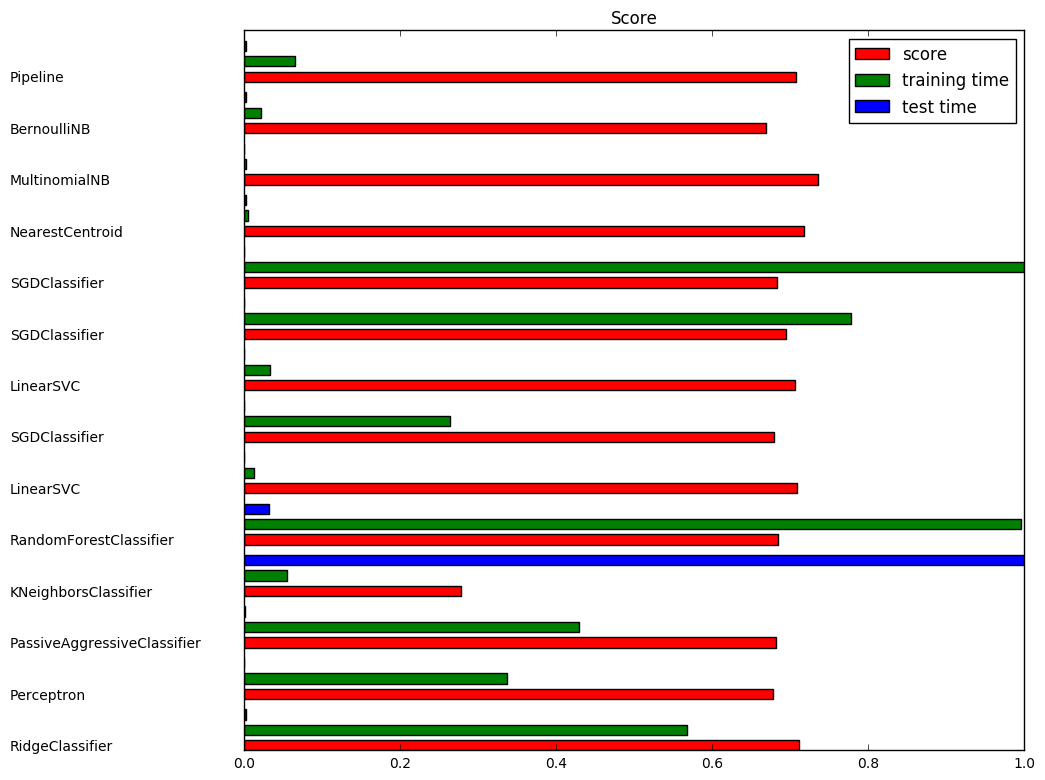

In [160]:
from time import time

from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.extmath import density
from sklearn import metrics

feature_names = np.array(tfidf.get_feature_names())

def trim(s):
    """Trim string to fit on terminal (assuming 80-column display)"""
    return s if len(s) <= 80 else s[:77] + "..."

###############################################################################
# Benchmark classifiers
def benchmark(clf):
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = metrics.accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % score)

    if hasattr(clf, 'coef_'):
        print("dimensionality: %d" % clf.coef_.shape[1])
        print("density: %f" % density(clf.coef_))

        if feature_names is not None:
            print("top 10 keywords per class:")
            for i, category in enumerate(categories):
                top10 = np.argsort(clf.coef_[i])[-10:]
                print(trim("%s: %s"
                      % (category, " ".join(feature_names[top10]))))
        print()


    print("classification report:")
    print(metrics.classification_report(y_test, pred,
                                        target_names=categories))


    print("confusion matrix:")
    print(metrics.confusion_matrix(y_test, pred))

    print()
    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time


results = []
for clf, name in (
        (RidgeClassifier(tol=1e-2, solver="lsqr"), "Ridge Classifier"),
        (Perceptron(n_iter=50), "Perceptron"),
        (PassiveAggressiveClassifier(n_iter=50), "Passive-Aggressive"),
        (KNeighborsClassifier(n_neighbors=10), "kNN"),
        (RandomForestClassifier(n_estimators=100), "Random forest")):
    print('=' * 80)
    print(name)
    results.append(benchmark(clf))

for penalty in ["l2", "l1"]:
    print('=' * 80)
    print("%s penalty" % penalty.upper())
    # Train Liblinear model
    results.append(benchmark(LinearSVC(loss='l2', penalty=penalty,
                                            dual=False, tol=1e-3)))

    # Train SGD model
    results.append(benchmark(SGDClassifier(alpha=.0001, n_iter=50,
                                           penalty=penalty)))

# Train SGD with Elastic Net penalty
print('=' * 80)
print("Elastic-Net penalty")
results.append(benchmark(SGDClassifier(alpha=.0001, n_iter=50,
                                       penalty="elasticnet")))

# Train NearestCentroid without threshold
print('=' * 80)
print("NearestCentroid (aka Rocchio classifier)")
results.append(benchmark(NearestCentroid()))

# Train sparse Naive Bayes classifiers
print('=' * 80)
print("Naive Bayes")
results.append(benchmark(MultinomialNB(alpha=.01)))
results.append(benchmark(BernoulliNB(alpha=.01)))

print('=' * 80)
print("LinearSVC with L1-based feature selection")
# The smaller C, the stronger the regularization.
# The more regularization, the more sparsity.
results.append(benchmark(Pipeline([
  ('feature_selection', LinearSVC(penalty="l1", dual=False, tol=1e-3)),
  ('classification', LinearSVC())
])))

# make some plots

indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(4)]

clf_names, score, training_time, test_time = results
training_time = np.array(training_time) / np.max(training_time)
test_time = np.array(test_time) / np.max(test_time)

plt.figure(figsize=(12, 8))
plt.title("Score")
plt.barh(indices, score, .2, label="score", color='r')
plt.barh(indices + .3, training_time, .2, label="training time", color='g')
plt.barh(indices + .6, test_time, .2, label="test time", color='b')
plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, clf_names):
    plt.text(-.3, i, c)

plt.show()

## Bonus: NLTK

NLTK is a vast library. Can you find some interesting bits to share with classmates?
Start here: http://www.nltk.org/